EDA for real AUS data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356453 entries, 0 to 356452
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   month_of_year           356453 non-null  object
 1   day_of_week             356453 non-null  object
 2   tariff_type             356453 non-null  object
 3   has_heat_pump           356453 non-null  bool  
 4   has_home_battery        356453 non-null  bool  
 5   has_solar_pv            356453 non-null  bool  
 6   has_electric_hot_water  356453 non-null  bool  
 7   has_electric_radiator   356453 non-null  bool  
 8   has_electric_vehicle    356453 non-null  bool  
 9   is_mains_gas            356453 non-null  bool  
 10  property_type_2         355048 non-null  object
 11  energy_rating           281258 non-null  object
 12  urbanity                355208 non-null  object
 13  kwh                     356453 non-null  object
dtypes: bool(7), object(7)
memory usage: 

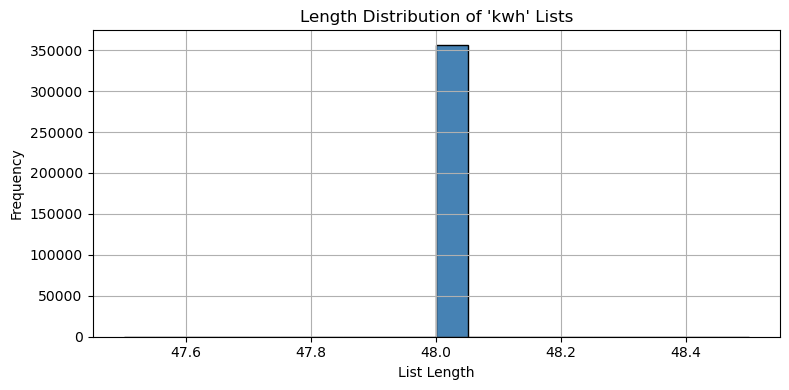

In [ ]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

df0 = pd.read_csv("FaradayV4/synthetic_data_batch_10.csv")
print(df0.info())
print(df0.head())
print(df0.isna().sum())
print("\n--- Fraction of missing values ---")
print((df0.isna().sum() / len(df0)).round(4))
df0.head()



kwh_clean = df0['kwh'].dropna()
# Convert string to list using safe parsing
kwh_lists = kwh_clean.apply(ast.literal_eval)

# Compute the length of each list
kwh_lengths = kwh_lists.apply(len)

# Display distribution summary
print("\n--- 'kwh' Length Distribution ---")
print(kwh_lengths.describe())

# Plot histogram of lengths
plt.figure(figsize=(8, 4))
plt.hist(kwh_lengths, bins=20, color='steelblue', edgecolor='black')
plt.title("Length Distribution of 'kwh' Lists")
plt.xlabel("List Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


Numeric columns: ['target', 'hour', 'dayofweek', 'month']
Categorical columns: ['category', 'id']

--- Sampled Data Description ---

              target          hour     dayofweek         month category  \
count   3.444937e+06  3.472128e+06  3.472128e+06  3.472128e+06  3472128   
unique           NaN           NaN           NaN           NaN        1   
top              NaN           NaN           NaN           NaN      30m   
freq             NaN           NaN           NaN           NaN  3472128   
mean    2.989297e-01  1.149412e+01  3.007952e+00  6.761571e+00      NaN   
min     0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00      NaN   
25%     6.700000e-02  5.000000e+00  1.000000e+00  4.000000e+00      NaN   
50%     1.460000e-01  1.100000e+01  3.000000e+00  7.000000e+00      NaN   
75%     3.350000e-01  1.700000e+01  5.000000e+00  1.000000e+01      NaN   
max     1.551300e+01  2.300000e+01  6.000000e+00  1.200000e+01      NaN   
std     4.276323e-01  6.924211e+00  2.0005

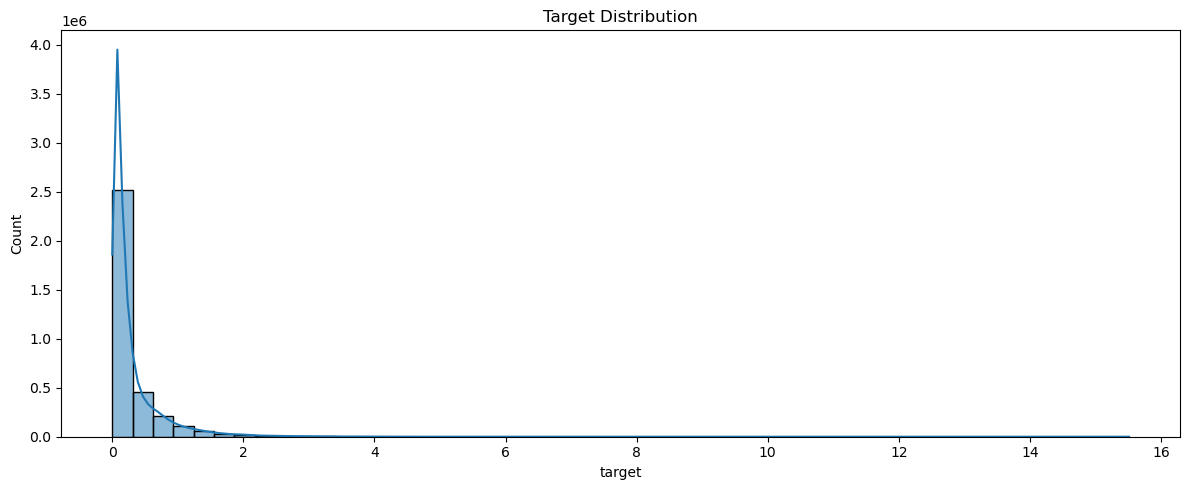

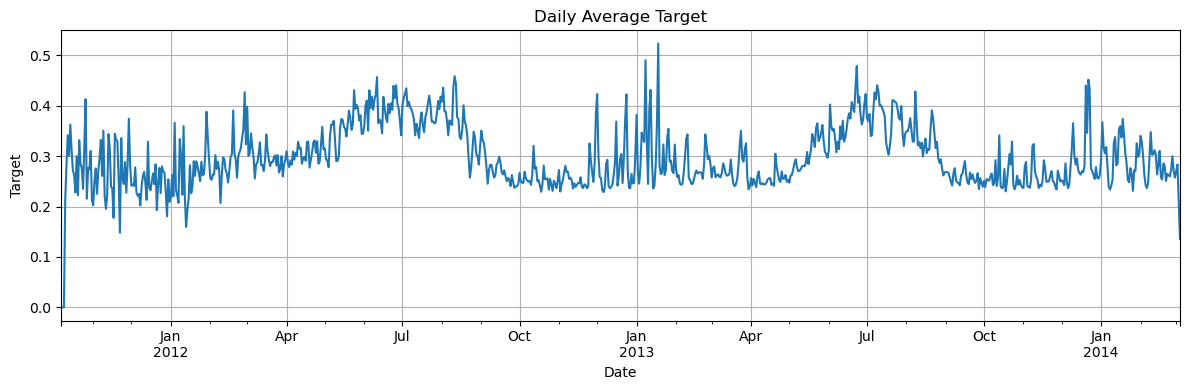

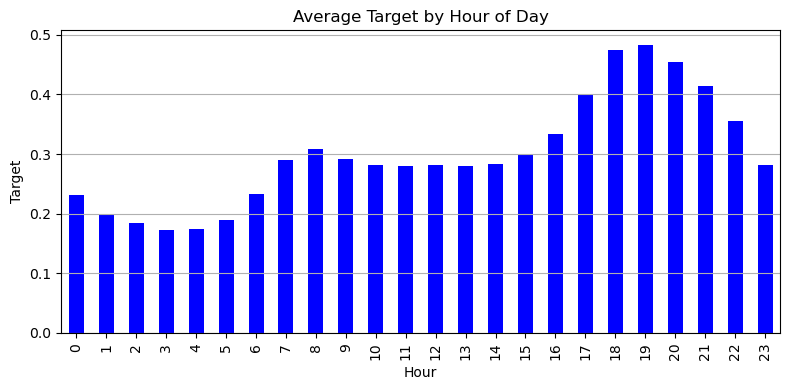

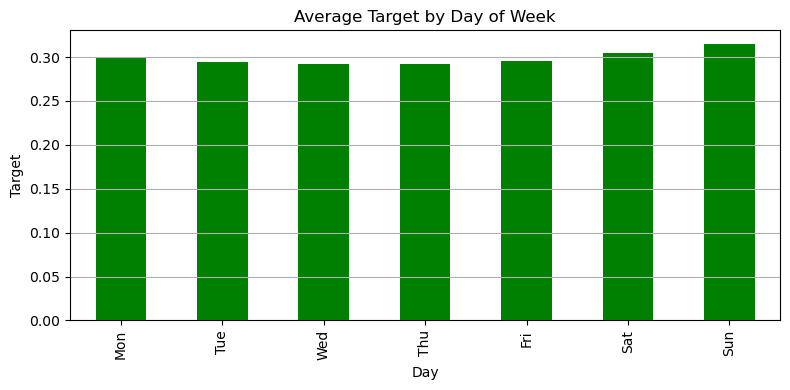

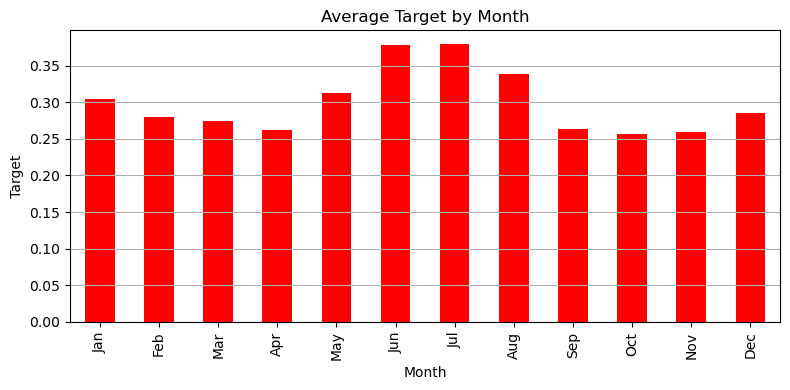

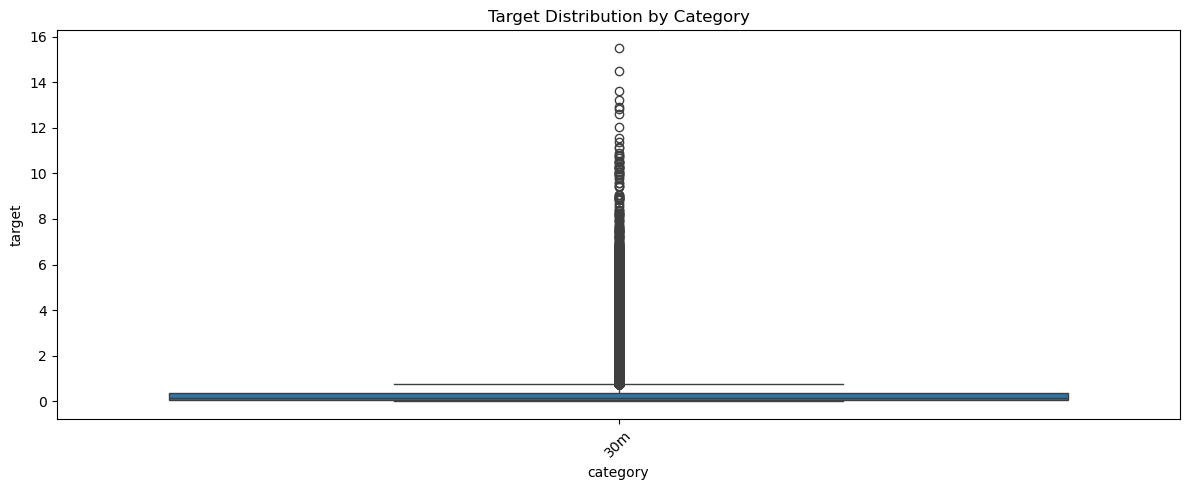

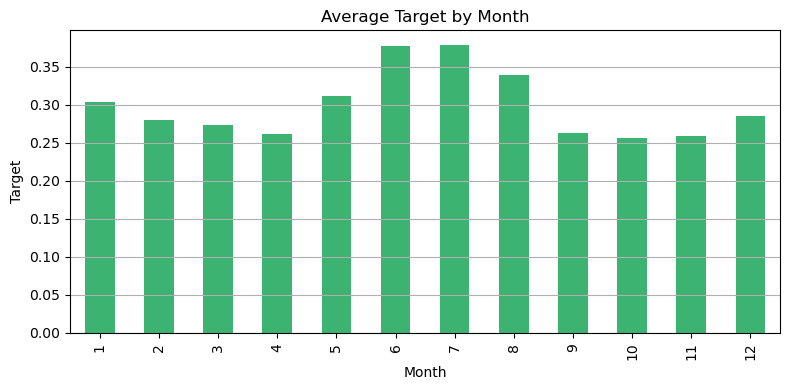

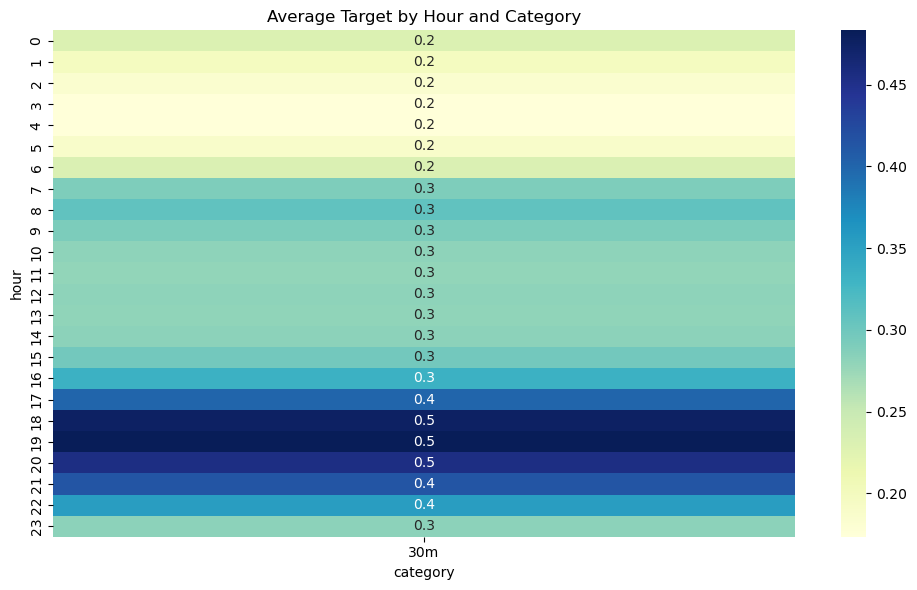

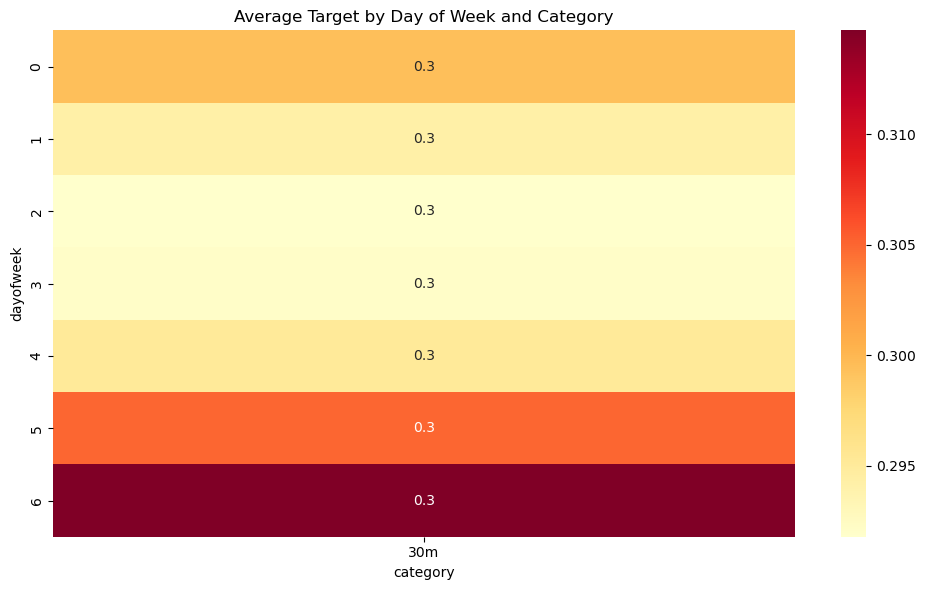

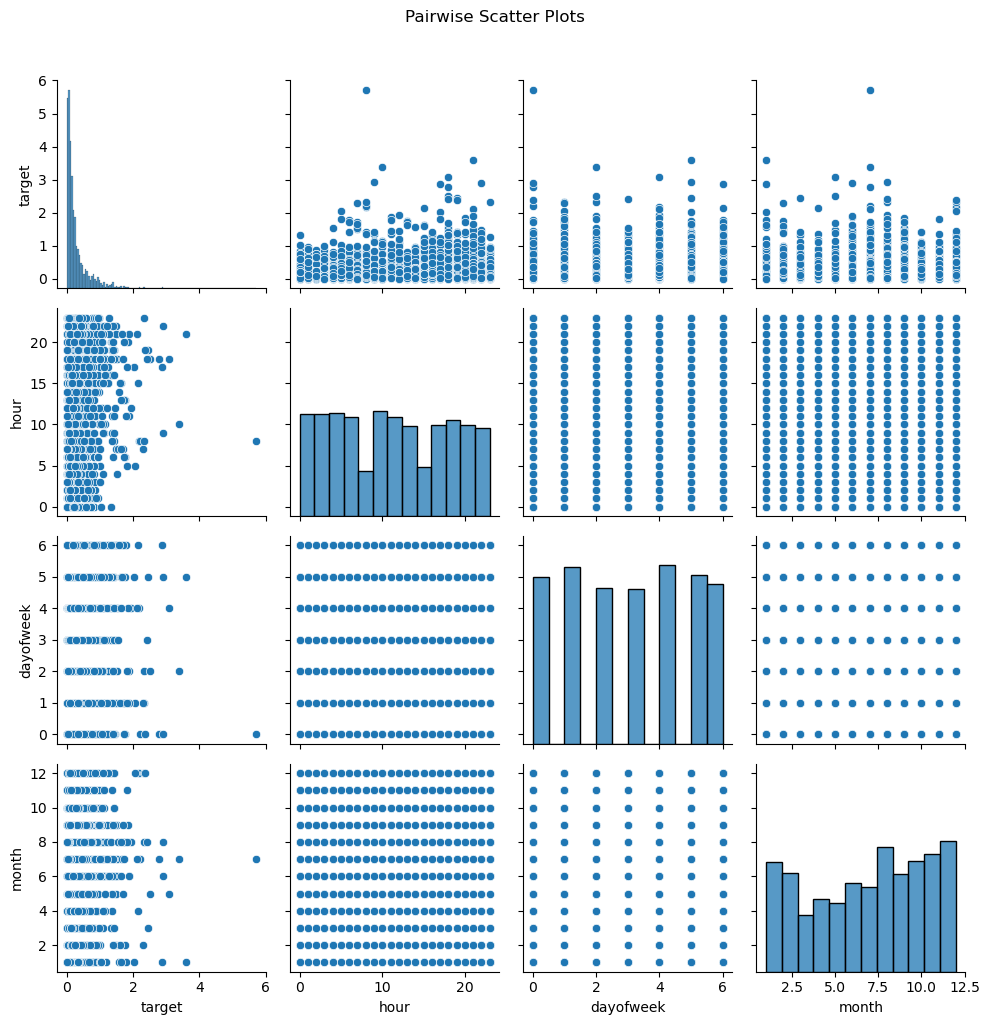

In [ ]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

columns_needed = ["datetime", "target", "category", "id"]
df = dd.read_parquet("aus_30m.parquet", columns=columns_needed, blocksize="32MB")

# Randomly sample 1% of the data
df_sampled = df.sample(frac=0.01, random_state=42).persist()
# Convert datetime column to datetime type and extract features
df_sampled["datetime"] = dd.to_datetime(df_sampled["datetime"], errors="coerce")
df_sampled["hour"] = df_sampled["datetime"].dt.hour
df_sampled["dayofweek"] = df_sampled["datetime"].dt.dayofweek
df_sampled["month"] = df_sampled["datetime"].dt.month

numeric_columns = [
    col for col in df_sampled.columns
    if pd.api.types.is_numeric_dtype(df_sampled[col]) and col != "id"
]

categorical_columns = [
    col for col in df_sampled.columns
    if pd.api.types.is_string_dtype(df_sampled[col])
]

print("Numeric columns:", numeric_columns)
print("Categorical columns:", categorical_columns)

df_pd_basic = df_sampled[numeric_columns + categorical_columns + ["datetime"]].compute()
print("\n--- Sampled Data Description ---\n")
print(df_pd_basic.describe(include="all"))

print("\n--- Missing Values in Sampled Data ---")
null_counts = df_sampled.isnull().sum().compute()
total_rows = len(df_sampled)
null_fractions = (null_counts / total_rows).round(4)
missing_df = pd.DataFrame({
    "Missing Count": null_counts,
    "Missing Fraction": null_fractions
})
print(missing_df)


target_values = df_sampled["target"].dropna().compute()
target_skew = skew(target_values)
print(f"\nTarget Skewness: {target_skew:.3f}")
if abs(target_skew) > 1:
    print("→ Highly Skewed")
elif abs(target_skew) > 0.5:
    print("→ Moderately Skewed")
else:
    print("→ Almost Symmetric")

plt.figure(figsize=(12, 5))
sns.histplot(target_values, bins=50, kde=True)
plt.title("Target Distribution")
plt.tight_layout()
plt.show()

df_pd = df_sampled[numeric_columns + categorical_columns + ["datetime"]].dropna().compute()
df_pd["category"] = df_pd["category"].astype(str)
df_pd.set_index("datetime", inplace=True)

plt.figure(figsize=(12, 4))
df_pd['target'].resample('D').mean().plot()
plt.title("Daily Average Target")
plt.ylabel("Target")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
df_pd.groupby(df_pd.index.hour)["target"].mean().plot(kind='bar', color='blue')
plt.title("Average Target by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Target")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df_pd.groupby(df_pd.index.dayofweek)["target"].mean().plot(kind='bar', color='green')
plt.xticks(ticks=range(7), labels=days)
plt.title("Average Target by Day of Week")
plt.xlabel("Day")
plt.ylabel("Target")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
days = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
         'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_pd.groupby(df_pd.index.month)["target"].mean().plot(kind='bar', color='red')
plt.xticks(ticks=range(12), labels=days)
plt.title("Average Target by Month")
plt.xlabel("Month")
plt.ylabel("Target")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

if "category" in df_pd.columns:
    plt.figure(figsize=(12, 5))
    top_cats = df_pd["category"].value_counts().index[:10]
    sns.boxplot(data=df_pd[df_pd["category"].isin(top_cats)], x="category", y="target")
    plt.title("Target Distribution by Category")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# plt.figure(figsize=(10, 6))
# corr = df_pd[numeric_columns].corr()
# sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
# plt.title("Correlation Heatmap (Numeric Features)")
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(8, 4))
df_pd.groupby(df_pd.index.month)["target"].mean().plot(kind='bar', color='mediumseagreen')
plt.title("Average Target by Month")
plt.xlabel("Month")
plt.ylabel("Target")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

if "category" in df_pd.columns:
    top_cats = df_pd["category"].value_counts().index[:5]
    pivot_hour = df_pd[df_pd["category"].isin(top_cats)].pivot_table(
        index="hour", columns="category", values="target", aggfunc="mean"
    )
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_hour, annot=True, fmt=".1f", cmap="YlGnBu")
    plt.title("Average Target by Hour and Category")
    plt.tight_layout()
    plt.show()

if "category" in df_pd.columns:
    pivot_day = df_pd[df_pd["category"].isin(top_cats)].pivot_table(
        index="dayofweek", columns="category", values="target", aggfunc="mean"
    )
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_day, annot=True, fmt=".1f", cmap="YlOrRd")
    plt.title("Average Target by Day of Week and Category")
    plt.tight_layout()
    plt.show()

if len(numeric_columns) >= 2:
    sample_for_scatter = df_pd[numeric_columns].sample(n=2000, random_state=42)
    sns.pairplot(sample_for_scatter)
    plt.suptitle("Pairwise Scatter Plots", y=1.02)
    plt.tight_layout()
    plt.show()
